In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

from openbb_terminal.sdk import openbb
import seaborn
import matplotlib.pyplot as plt

In [2]:
symbols = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]

data = openbb.economy.index(symbols, start_date="2014-01-01", end_date="2015-01-01")

yfinance: download(show_errors=False) argument is deprecated and will be removed in future version. Do this instead to suppress error messages: logging.getLogger('yfinance').setLevel(logging.CRITICAL)


## Step 2: Find co-integrated pairs

In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [4]:
scores, pvalues, pairs = find_cointegrated_pairs(data)

<AxesSubplot:>

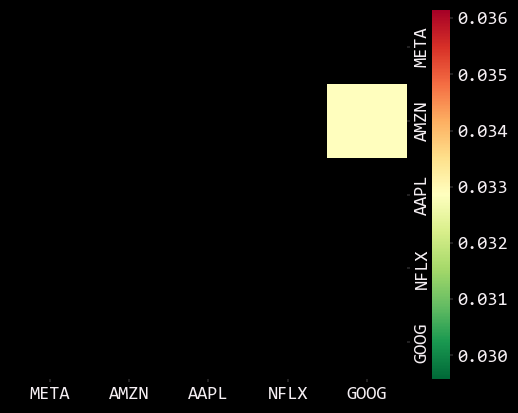

In [9]:
scores, pvalues, pairs = find_cointegrated_pairs(data)

seaborn.heatmap(
    pvalues, 
    xticklabels=symbols, 
    yticklabels=symbols, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.10)
)

In [10]:
S1 = data.AMZN
S2 = data.AAPL

In [13]:
score, pvalue, _ = coint(S1, S2)
pvalue

0.1006816433493466

In [14]:
S1

Date
2014-01-02    19.898500
2014-01-03    19.822001
2014-01-06    19.681499
2014-01-07    19.901501
2014-01-08    20.096001
                ...    
2014-12-24    15.151500
2014-12-26    15.454500
2014-12-29    15.602000
2014-12-30    15.515000
2014-12-31    15.517500
Name: AMZN, Length: 252, dtype: float64

In [15]:
S1 = sm.add_constant(S1)

In [16]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.AMZN
b = results.params['AMZN']
spread = S2 - b * S1

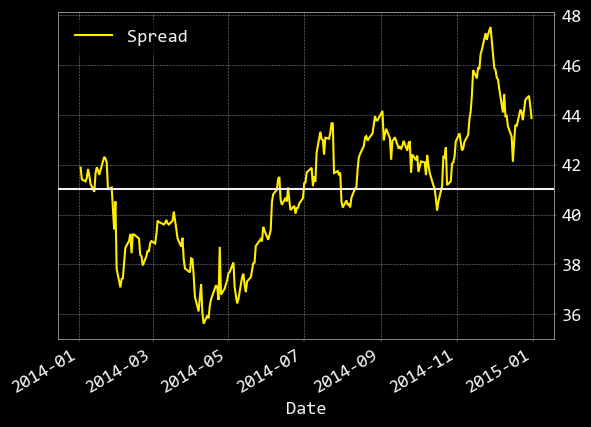

In [17]:
spread.plot()
plt.axhline(spread.mean())
plt.legend(['Spread']);

## Step 4: Build a simple trading strategy

In [18]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

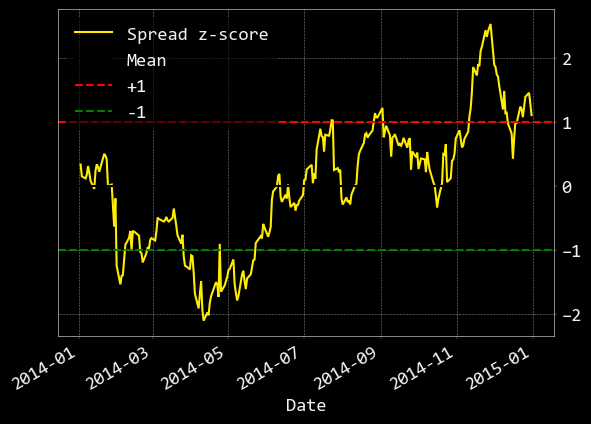

In [19]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [20]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

In [21]:
# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

You can plot the trading signal along with the position.

<AxesSubplot:xlabel='Date'>

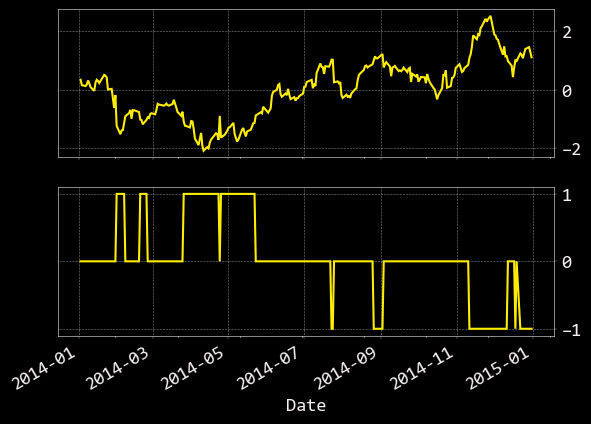

In [22]:
fig, ax = plt.subplots(2, sharex=True)
trades.loc[:, "signal"].plot(ax=ax[0])
trades.loc[:, "side"].plot(ax=ax[1])

<AxesSubplot:xlabel='Date'>

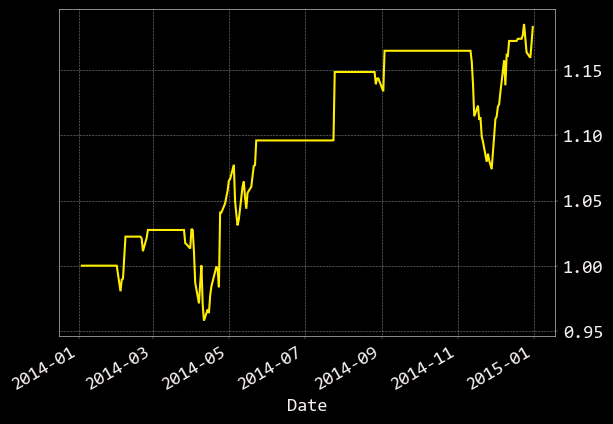

In [23]:
returns = trades.side.shift(1) * trades.position.apply(np.log).diff(1)
returns.cumsum().apply(np.exp).plot()